# DTSA 5511 FINAL PROJECT
GitHub link: https://github.com/jhoglund1/DTSA5511-IntroToDeepLearning/tree/main

In [ ]:
pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
pip install git+https://github.com/dreamquark-ai/tabnet

  Cloning https://github.com/dreamquark-ai/tabnet to /tmp/pip-req-build-4kjemh_5
  Running command git clone --filter=blob:none --quiet https://github.com/dreamquark-ai/tabnet /tmp/pip-req-build-4kjemh_5
  Resolved https://github.com/dreamquark-ai/tabnet to commit 2c0c4ebd2bb1cb639ea94ab4b11823bc49265588
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import pandas as pd
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## DATA INGESTION

For this project, the data used is from the UCI Machine Learning Repository (source below). The data was collected from various hospitals, clinics, and maternal heath care centers in rural areas in Bangladesh. It provides information in order to measure risk for maternal mortality from 6 numerical features: Age, Systolic Blood Pressure (SystolicBP), Diastolic Blood Pressure (DiastolicBP), Blood Sugar (BS), Body Temperature (BodyTemp), and Heart Rate (HeartRate). The categorical target feature is labelled as RiskLevel and has three categories: Low Risk, Medium Risk, and High Risk. There 1014 total instances.

Source:
Ahmed, M. (2020). Maternal health risk. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/863/maternal+health+risk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read in dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Maternal Health Risk Data Set.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


## DATA CLEANING

##### Check for null values in dataset
No null values exist in this dataset so no rows need to be dropped.

In [ ]:
data.isnull().sum()

,0
Age,0
SystolicBP,0
DiastolicBP,0
BS,0
BodyTemp,0
HeartRate,0
RiskLevel,0


##### Refactor target feature
Refactor RiskLevel feature from strings to ints in order calculate the score for the created models. Mapping is: 0 - Low Risk, 1 - Med Risk, 2 - High Risk

In [ ]:
data['RiskLevel'] = data['RiskLevel'].map({'low risk':0, 'mid risk':1, 'high risk':2}).astype(int)

##### Check for categorical data imbalances
For the only categorical feature, we will print the percentage for how many of each category exist in the dataset as well as plot the counts for each risk level for visualization.
Low Risk has the highest amount of instances with 40% of the total amount while High Risk has the lowest amount with ~27% of the instances.
While the categories are not evenly split, there is still a good amount of the High Risk category (> 15%), so no imbalance adjustments for High Risk need to occur.

RiskLevel
0    0.400394
1    0.331361
2    0.268245
Name: count, dtype: float64


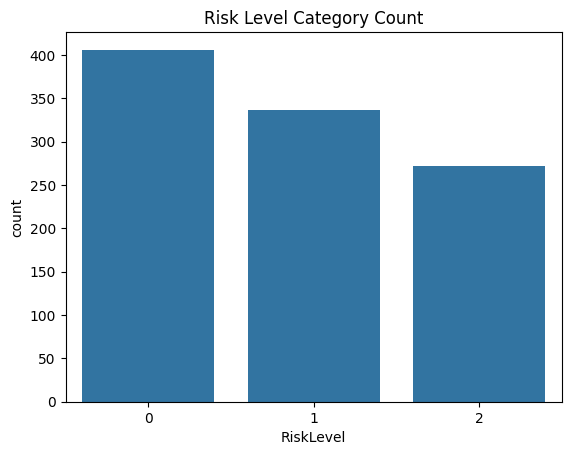

In [ ]:
print(data['RiskLevel'].value_counts() / len(data))
sns.countplot(data, x='RiskLevel').set_title('Risk Level Category Count')
plt.show()

##### Check for numerical data imbalances

Plot a box plot with the 6 numerical features. There is a small outlier for Age but it is very close to the upper quartile so it is reasonable to keep it. There are no outliers for DiastolicBP. The outliers for SystolicBP, BS, BodyTemp, and HeartRate are considered below.

<Axes: >

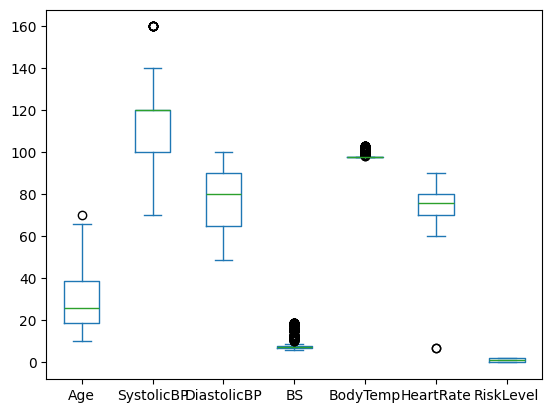

In [ ]:
data.plot(kind='box')

###### Check SystolicBP outliers

The boxplot shows an outlier around 160. A further look at SystolicBP's greater than 150 show that there are 10 rows where the SystolicBP is 160. Further research says that 160 is an approprirate possible value for SystolicBP, so these rows can stay.

<Axes: >

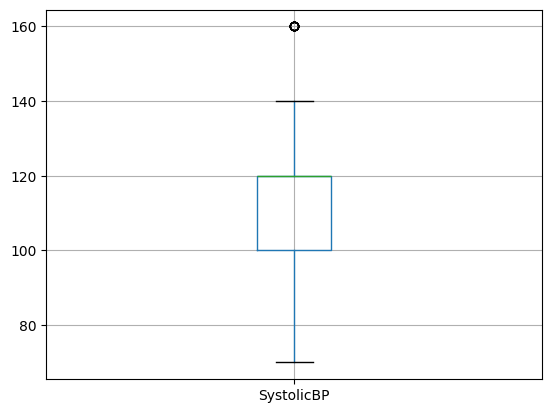

In [ ]:
data.boxplot(['SystolicBP'])

In [ ]:
data.loc[(data['SystolicBP'] >= 150)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
123,40,160,100,19.0,98.0,77,2
130,40,160,100,19.0,98.0,77,2
166,40,160,100,19.0,98.0,77,2
262,40,160,100,19.0,98.0,77,2
362,40,160,100,19.0,98.0,77,2
538,40,160,100,19.0,98.0,77,2
583,40,160,100,19.0,98.0,77,2
689,40,160,100,19.0,98.0,77,2
961,40,160,100,19.0,98.0,77,2
994,40,160,100,19.0,98.0,77,2


###### Check HeartRate outliers

The boxplot shows an outlier below 10. A further look at HeartRate's less than 40 show that there are 2 instances where the HeartRate is 7. This is an essentially impossible value for a heart rate. Since there are only 2 instances these rows can just be removed from the dataset.

<Axes: >

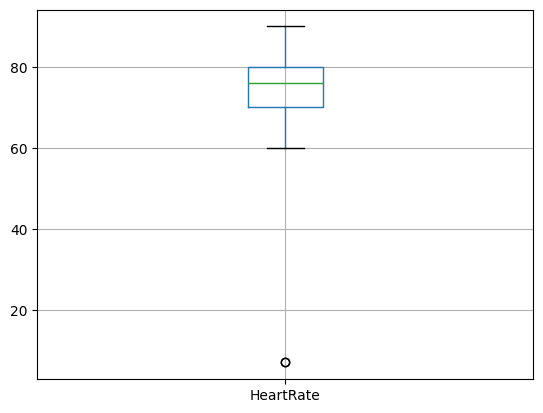

In [ ]:
data.boxplot(['HeartRate'])

In [ ]:
data.loc[(data['HeartRate'] < 40)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,0
908,16,120,75,7.9,98.0,7,0


In [ ]:
data = data.drop(data[data['HeartRate'] == 7].index)

###### Check BS outliers

The boxplot shows several outliers ranging from 10 to ~19. A further look at Blood Sugar values less than 10, show that there are 210 instances of high BS levels. Further research shows that all these outliers can be realistic values for Blood Sugar, so all these outliers can stay in the dataset.

<Axes: >

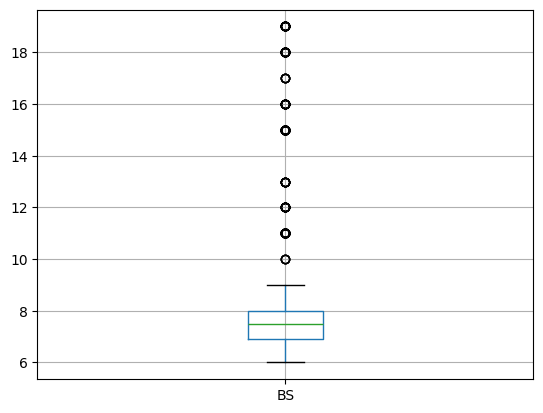

In [ ]:
data.boxplot(['BS'])

In [ ]:
data.loc[(data['BS'] >= 10)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
7,35,85,60,11.0,102.0,86,2
9,42,130,80,18.0,98.0,70,2
14,48,120,80,11.0,98.0,88,1
...,...,...,...,...,...,...,...
1008,48,120,80,11.0,98.0,88,2
1009,22,120,60,15.0,98.0,80,2
1010,55,120,90,18.0,98.0,60,2
1011,35,85,60,19.0,98.0,86,2


###### Check BodyTemp outliers

The boxplot shows several outliers ranging from >98 to 103. A further look at BodyTemp levels greater than 98, show that there are 210 instances of high Body Temperatur levels. All these values are realistic options for Body Temperature, so all these outliers can stay in the dataset.

<Axes: >

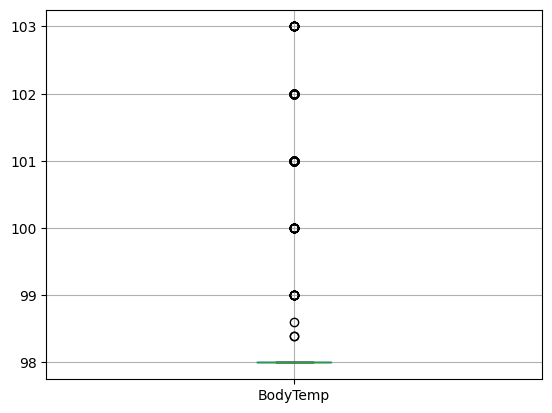

In [ ]:
data.boxplot(['BodyTemp'])

In [ ]:
data.loc[(data['BodyTemp'] > 98)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
2,29,90,70,8.00,100.0,80,2
7,35,85,60,11.00,102.0,86,2
13,20,120,75,7.01,100.0,70,1
18,30,120,80,6.90,101.0,76,1
35,12,95,60,6.10,102.0,60,0
...,...,...,...,...,...,...,...
1000,12,90,60,11.00,102.0,60,2
1004,13,90,65,9.00,101.0,80,2
1005,17,90,65,7.70,103.0,67,2
1006,17,85,60,6.30,102.0,86,2


#### Data Cleaning Summary

This dataset was relatively clean. No nan values existed. There were 2 outliers in the BS feature that gave impossible values, so those 2 rows containing the outliers were removed. The outliers were accessed and determined to be realistic values. The target feature was checked for data imbalance and determined to be appropriately balanced. The categories for the target were changed to numerical representations to aid in model evaluation later. It will be essential to carry the mapping forward throughout the experiment in order to properly associate the number to the risk level. Info and descriptions for the cleaned dataset is below.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1012 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1012 non-null   int64  
 1   SystolicBP   1012 non-null   int64  
 2   DiastolicBP  1012 non-null   int64  
 3   BS           1012 non-null   float64
 4   BodyTemp     1012 non-null   float64
 5   HeartRate    1012 non-null   int64  
 6   RiskLevel    1012 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 63.2 KB


In [ ]:
data.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
count,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000
mean,29.899209,113.184783,76.463439,8.727619,98.666403,74.434783,0.869565
std,13.473560,18.419618,13.899372,3.296583,1.372421,7.521857,0.807227
min,10.000000,70.000000,49.000000,6.000000,98.000000,60.000000,0.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,0.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000,1.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000,2.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000,2.000000


## EXPLORATORY DATA ANALYSIS

##### Histogram
The histogram plotted below shows that Age has a right skewed somewhat normal distribution. The other 4 features have data that is spread out enough so as to not be able to make any assumptions about the distribution of each feature. The HeartRate feature has a large gap of reported heart rates between ~ 72 and 75. It seems unusual that there would be no heart rates reported at the potential peak of the distribution. This appears to possibly be a rounding error in the data collection process. It doesn't seem to be too impactful for the overall models but we will keep it in mind if Heart Rate is an important feature.

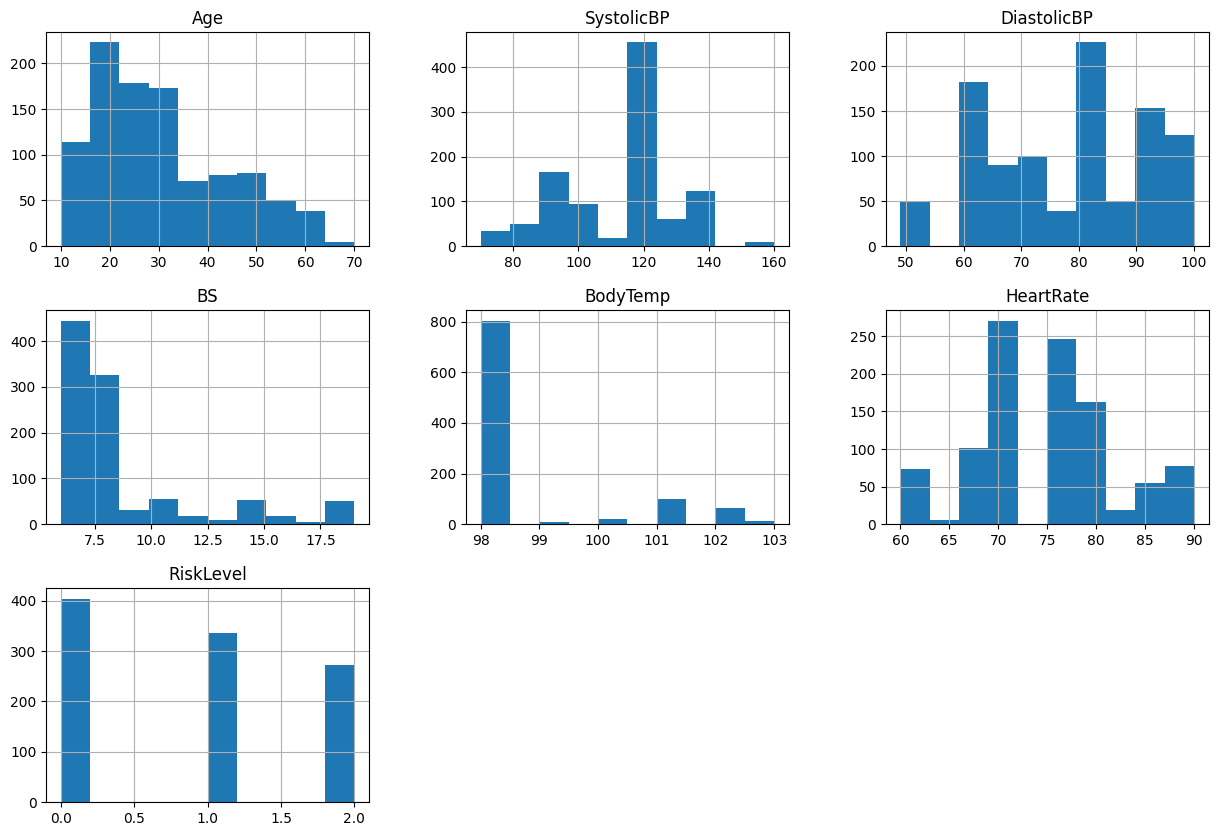

In [ ]:
data.hist(figsize=(15, 10))
plt.show()

##### Pairwise Plot

The pairwise plot shows that most of the feature pairs have relatively evenly distributed data points, which shows no collinearity between the features. The pairs relating to BS have some bunching in the lower part of the charts but this makes sense since the majority of the BS values are on the lower end. There may a slight linear relationship between SystolicBP and DiastolicBP, which we will pay attention to in the correlation matrix chart further below.

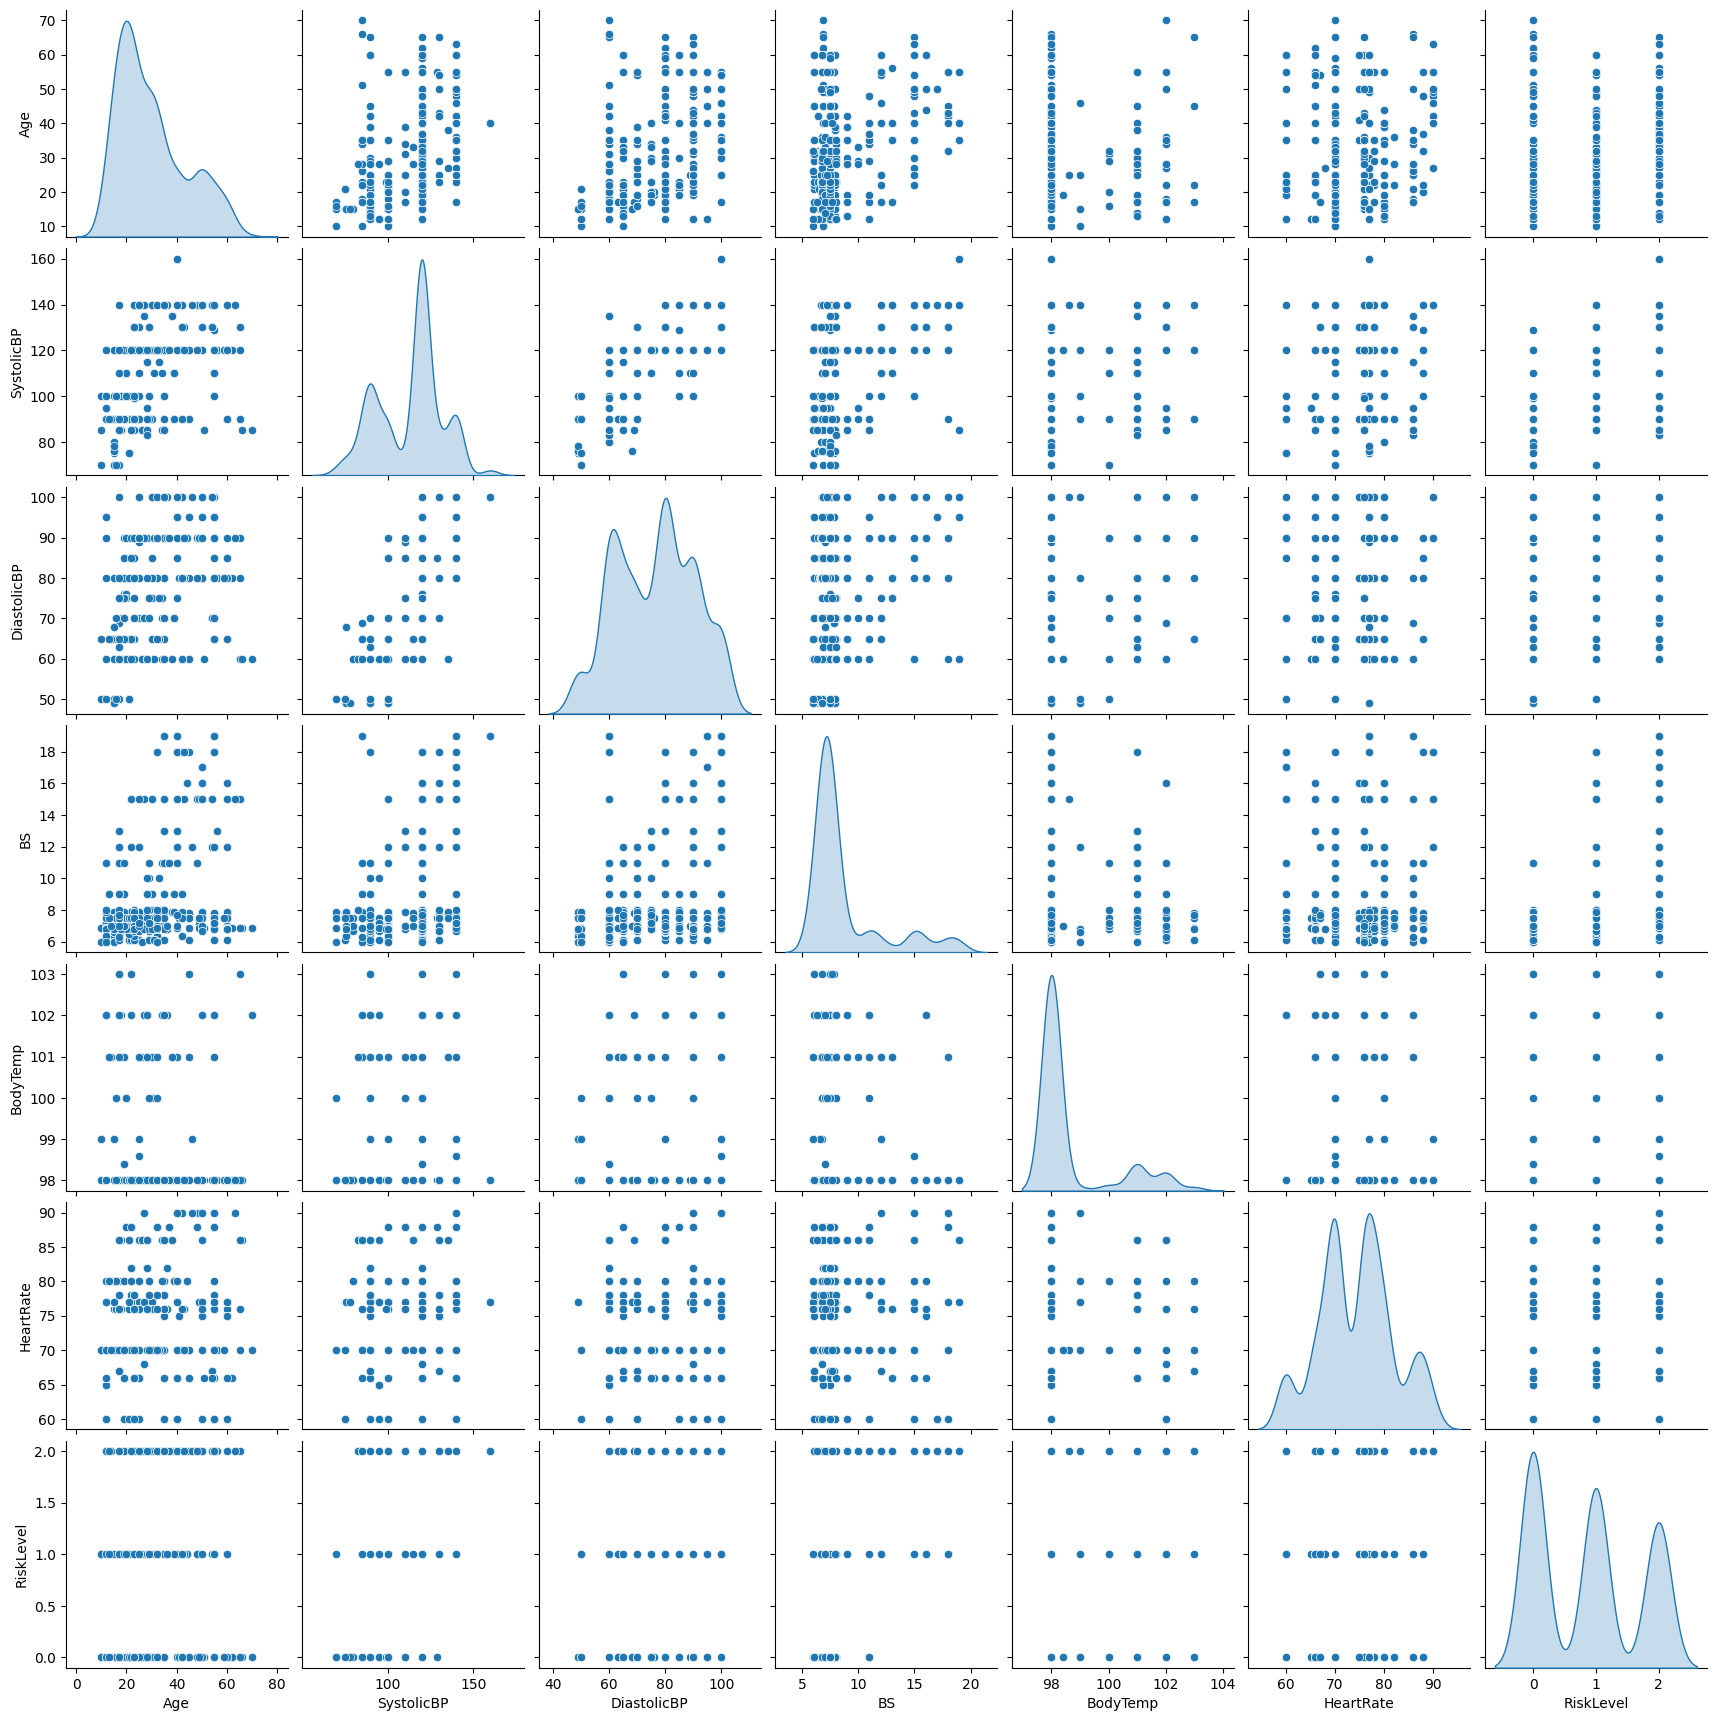

In [ ]:
sns.pairplot(data, diag_kind = "kde")
plt.show()

##### Correlation Matrix
The correlation matrix heatmap below shows several things. First, there is a higher correlation between BS (blood sugar) and the target variable, RiskLevel. It is not quite enough to be considered highly correlated, but we will note that BS appears to be the most important feature for assessing RiskLevel. There is also a high correlation between the SystolicBP and DiastolicBP features. This makes sense since those are the two part of a blood pressure measurement that are always taken together. In order to remove the this highly correlated relationship, we will remove DiastolicBP from the dataset, since research suggests that SystolicBP is the most important blood pressure measurement (https://pubmed.ncbi.nlm.nih.gov/12698068/#:~:text=In%20this%20review%20we%20compare,a%20better%20predictor%20of%20risk).

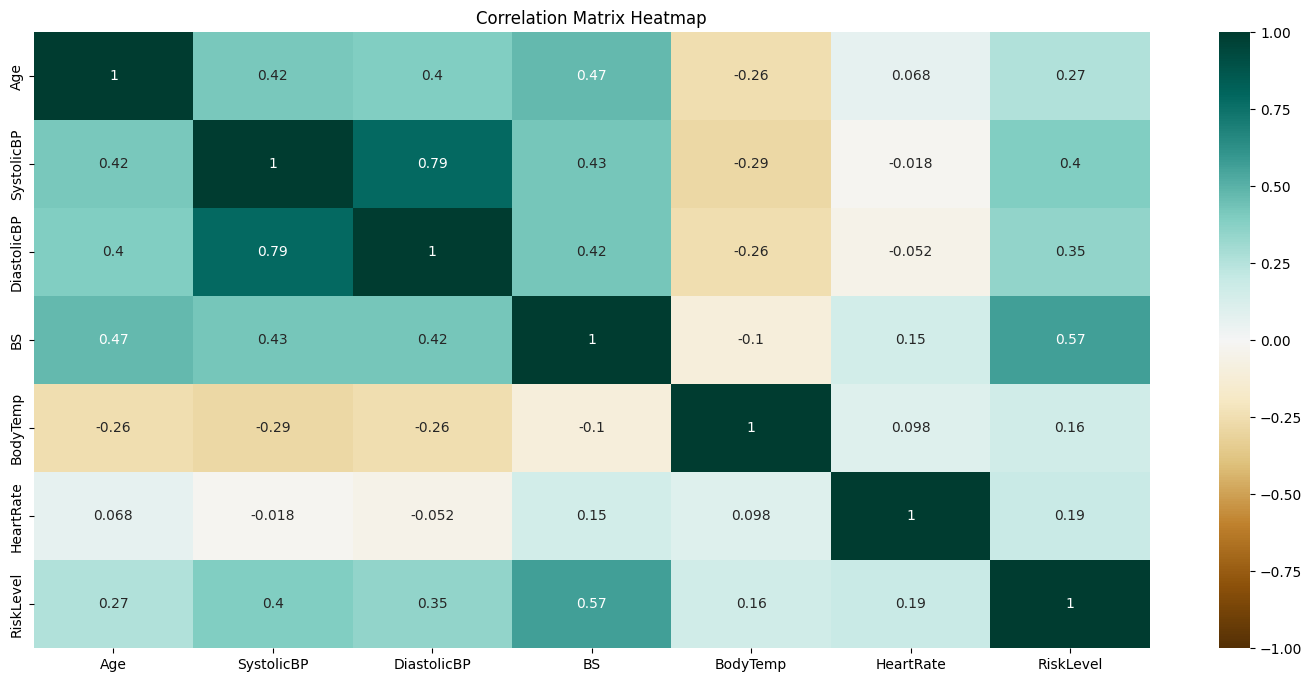

In [ ]:
plt.figure(figsize=(18, 8))
hmap = sns.heatmap(data.corr(), annot = True, vmin = -1, vmax = 1, cmap = "BrBG")
hmap.set_title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
data = data.drop(['DiastolicBP'], axis=1)

### EDA Summary

* The histogram revealed make different data structures across the features, so no common distribution can be assumed for the dataset.There is a small discrepancy with the HeartRate feature that is noted.
* The pairwise plot showed evenly distributed data points across most of the feature pairs, except for the SystolicBP and DiastolicBP pair which showed a slightly linear relationship.
* The correlation matrix showed a slightly high correlation between BS and RiskLevel. It was not high enough to remove, but was noted for further analysis. The heatmap also showed a high correlation between the SystolicBP and DiastolicBP features. The DiastolicBP feature was removed from the dataset in order to eliminate that colinear relationship. Information about the dataset after the updates is below.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1012 entries, 0 to 1013
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         1012 non-null   int64  
 1   SystolicBP  1012 non-null   int64  
 2   BS          1012 non-null   float64
 3   BodyTemp    1012 non-null   float64
 4   HeartRate   1012 non-null   int64  
 5   RiskLevel   1012 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 55.3 KB


## MODEL BUILDING AND TRAINING

##### Model Overview
The model deteremined to be the most approriate for this dataset is the TabNet model. Since the data is tabular, other more common deep learning architectures, like CNNs, that determine relationships spatially will not work as well. TabNet instead processes features sequentially at each decision step using decision tree-like feature selection and instance wise feature importance.

The TabNet model consists of a set of sequential steps where each step includes an encoder that has a feature transformer, an attentive transformer, and an attention mask. There is also a decoder that has a feature transformer which outputs the final predictions.

TabNet can have a higher computational cost compared to simpler models but it provides better performance for tabular data and can also provide insights into feature importance.

##### Data Normalization and Test Train Split
The kNN model needs to use normalized data since it uses distances in order to calculate the classification. The code uses the MinMaxScaler in order to normalize the data. Train and test split datasets are created from the normalized data for the kNN classifier and from the non-normalized data for use in the other 3 classifiers.

In [ ]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_data_minmax = MinMaxScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_data_minmax,columns=['Age', 'SystolicBP', 'BS', 'BodyTemp', 'HeartRate'])

# normalized train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size =0.2, random_state = 1)

##### Hyperparameter Tuning and Cross Validation

The hyperparameters tuned for this model are:

* n_d
  * This is the width of the decision prediction layer. It is cross validated with values of 8, 16, 32, and 64.
* n_a
  * This is the width of the attention embedding for each mask. It is cross validated with values of 8, 16, 32, and 64. Must match the n_d value.
* gamma
  * This is the coeficient for feature reusage in the masks. It is cross validated with a range of values from 1.0 to 2.0 with steps of 0.1.
* momentum
  * This is the momentum for batch normalization. It is cross validated with a range of values from 0.02 to 0.4 with steps of 0.02.
* n_steps
  * This is the number of steps in the architecture. It is cross validated with a range of values from 3 to 10 with steps of 1.
* mask_type  
  * This is the masking function used for selecting features. It is cross validated with options of sparsemax and entmax.

A randomized search for cross validaton is conducted to find the best parameters and the best ones selected are printed out.

#### Model 1 - Width 8

This model has a layer width (n_d) and embedding width (n_a) of 8 each. The best values of the parameters are n_steps equal to 9, momentum equal to 0.06, mask_type equal to sparsemax, and gamma equal to 1.2.

In [ ]:
model_params = {'gamma':[i for i in np.arange(1.0,2.0,0.1)],
                'momentum':[i for i in np.arange(0.02,0.4,0.02)],
                'n_steps':[i for i in np.arange(3,10,1)],
                'mask_type':['entmax','sparsemax']}

model_8 = TabNetClassifier(n_d=8,
                           n_a=8,
                           optimizer_fn=torch.optim.Adam,
                           scheduler_params = {"gamma": 0.95,
                                               "step_size": 5},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0,
                           seed=1)

tabnet_8 = RandomizedSearchCV(model_8, model_params, n_iter=30, scoring='accuracy', random_state=1)

tabnet_8.fit(X_train.values,y_train.values,
             eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],
             eval_name=['train', 'test'],
             eval_metric=['accuracy'],
             loss_fn=torch.nn.KLDivLoss,
             patience=5,
             max_epochs=15)

y_pred_8 = tabnet_8.predict(X_test.values)

print(tabnet_8.best_params_)


Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.31527

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.31527

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.31527

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.31527

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.31527

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.24138

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.24138

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.24138

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.24138

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.24138

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.40887

Early stopping occur

##### Feature Importance
The graph below shows the feature importance for each of the features for the 8 Width Model. The BodyTemp feature was the least impactful while the HeartRate feature was the most impactful. There is a difference of 0.181 between the least and the most important feature. All the features have positive importance so they are all considered important to this model.

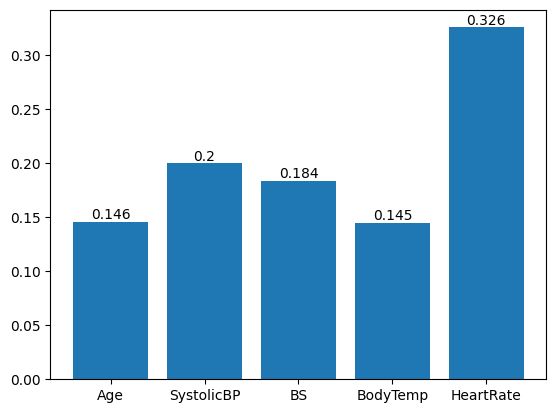

In [ ]:
importance = []
for i in range(len(tabnet_8.best_estimator_.feature_importances_)):
    importance.append(round(tabnet_8.best_estimator_.feature_importances_[i],3))

plt.bar([x for x in range(len(importance))], importance)
plt.xticks([0,1,2,3,4],X.columns)
for i in range(len(X.columns)):
        plt.text(i,importance[i],importance[i], ha ='center', va = 'bottom')
plt.show()

#### Model 2 - Width 16

This model has a layer width (n_d) and embedding width (n_a) of 16 each. The best values of the parameters are n_steps equal to 3, momentum equal to 0.12, mask_type equal to sparsemax, and gamma equal to 1.7.

In [ ]:
model_params = {'gamma':[i for i in np.arange(1.0,2.0,0.1)],
                'momentum':[i for i in np.arange(0.02,0.4,0.02)],
                'n_steps':[i for i in np.arange(3,10,1)],
                'mask_type':['entmax','sparsemax']}

model_16 = TabNetClassifier(n_d=16,
                            n_a=16,
                            optimizer_fn=torch.optim.Adam,
                            scheduler_params = {"gamma": 0.95,
                                                "step_size": 5},
                            scheduler_fn=torch.optim.lr_scheduler.StepLR,
                            verbose=0,
                            seed=1)

tabnet_16 = RandomizedSearchCV(model_16, model_params, n_iter=30, scoring='accuracy', random_state=1)

tabnet_16.fit(X_train.values,y_train.values,
              eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],
              eval_name=['train', 'test'],
              eval_metric=['accuracy'],
              loss_fn=torch.nn.KLDivLoss,
              patience=5,
              max_epochs=15)

y_pred_16 = tabnet_16.predict(X_test.values)

print(tabnet_16.best_params_)


Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.38916

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.38916

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.38916

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.38916

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.38916

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.24631

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.24631

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.24631

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.24631

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.24631

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.37931

Early stopping occur

##### Feature Importance
The graph below shows the feature importance for each of the features for the 16 Width Model. The BodyTemp feature was the least impactful while the HeartRate feature was the most impactful. There is a difference of 0.262 between the least and the most important feature. All the features have positive importance so they are all considered important to this model.

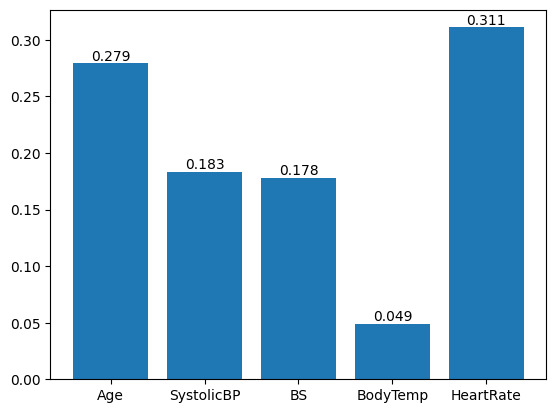

In [ ]:
importance = []
for i in range(len(tabnet_16.best_estimator_.feature_importances_)):
    importance.append(round(tabnet_16.best_estimator_.feature_importances_[i],3))

plt.bar([x for x in range(len(importance))], importance)
plt.xticks([0,1,2,3,4],X.columns)
for i in range(len(X.columns)):
        plt.text(i,importance[i],importance[i], ha ='center', va = 'bottom')
plt.show()

#### Model 3 - Width 32

This model has a layer width (n_d) and embedding width (n_a) of 32 each. The best values of the parameters are n_steps equal to 7, momentum equal to 0.26, mask_type equal to entmax, and gamma equal to 1.2.

In [ ]:
model_params = {'gamma':[i for i in np.arange(1.0,2.0,0.1)],
                'momentum':[i for i in np.arange(0.02,0.4,0.02)],
                'n_steps':[i for i in np.arange(3,10,1)],
                'mask_type':['entmax','sparsemax']}

model_32 = TabNetClassifier(n_d=32,
                            n_a=32,
                            optimizer_fn=torch.optim.Adam,
                            scheduler_params = {"gamma": 0.95,
                                                "step_size": 5},
                            scheduler_fn=torch.optim.lr_scheduler.StepLR,
                            verbose=0,
                            seed=1)

tabnet_32 = RandomizedSearchCV(model_32, model_params, n_iter=30, scoring='accuracy', random_state=1)

tabnet_32.fit(X_train.values,y_train.values,
              eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],
              eval_name=['train', 'test'],
              eval_metric=['accuracy'],
              loss_fn=torch.nn.KLDivLoss,
              patience=5,
              max_epochs=15)

y_pred_32 = tabnet_32.predict(X_test.values)

print(tabnet_32.best_params_)


Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.42365

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.42365

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.42365

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.42365

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.42365

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.30049

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.30049

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.30049

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.30049

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.30049

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.42857

Early stopping occur

##### Feature Importance
The graph below shows the feature importance for each of the features for the 32 Width Model. The Age feature was the least impactful while the SystolicBP feature was the most impactful. There is a difference of 0.213 between the least and the most important feature. All the features have positive importance so they are all considered important to this model.

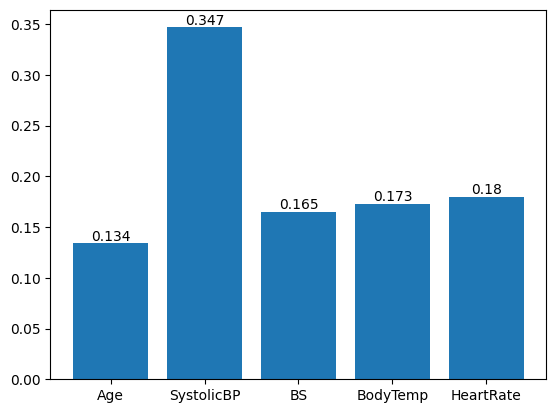

In [ ]:
importance = []
for i in range(len(tabnet_32.best_estimator_.feature_importances_)):
    importance.append(round(tabnet_32.best_estimator_.feature_importances_[i],3))

plt.bar([x for x in range(len(importance))], importance)
plt.xticks([0,1,2,3,4],X.columns)
for i in range(len(X.columns)):
        plt.text(i,importance[i],importance[i], ha ='center', va = 'bottom')
plt.show()

#### Model 4 - Width 64

This model has a layer width (n_d) and embedding width (n_a) of 64 each. The best values of the parameters are n_steps equal to 6, momentum equal to 0.24, mask_type equal to sparsemax, and gamma equal to 1.8.

In [ ]:
model_params = {'gamma':[i for i in np.arange(1.0,2.0,0.1)],
                'momentum':[i for i in np.arange(0.02,0.4,0.02)],
                'n_steps':[i for i in np.arange(3,10,1)],
                'mask_type':['entmax','sparsemax']}

model_64 = TabNetClassifier(n_d=64,
                            n_a=64,
                            optimizer_fn=torch.optim.Adam,
                            scheduler_params = {"gamma": 0.95,
                                                "step_size": 5},
                            scheduler_fn=torch.optim.lr_scheduler.StepLR,
                            verbose=0,
                            seed=1)

tabnet_64 = RandomizedSearchCV(model_64, model_params, n_iter=30, scoring='accuracy', random_state=1)

tabnet_64.fit(X_train.values,y_train.values,
              eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],
              eval_name=['train', 'test'],
              eval_metric=['accuracy'],
              loss_fn=torch.nn.KLDivLoss,
              patience=5,
              max_epochs=15)

y_pred_64 = tabnet_64.predict(X_test.values)

print(tabnet_64.best_params_)


Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.31034

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.31034

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.31034

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.31034

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.31034

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.30049

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.30049

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.30049

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.30049

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.30049

Early stopping occurred at epoch 5 with best_epoch = 0 and best_test_accuracy = 0.31034

Early stopping occur

##### Feature Importance
The graph below shows the feature importance for each of the features for the 64 Width Model. The BodyTemp feature was the least impactful while the Age feature was the most impactful. There is a difference of 0.346 between the least and the most important feature. All the features have positive importance so they are all considered important to this model.

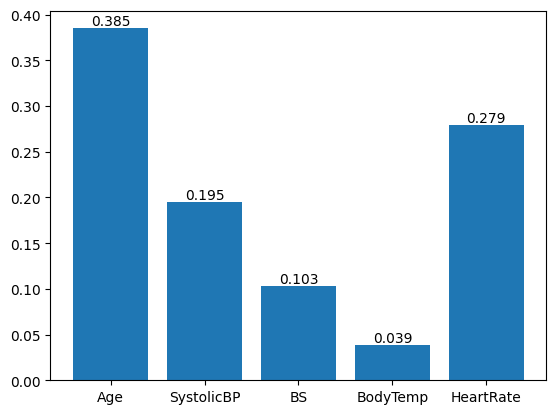

In [ ]:
importance = []
for i in range(len(tabnet_64.best_estimator_.feature_importances_)):
    importance.append(round(tabnet_64.best_estimator_.feature_importances_[i],3))

plt.bar([x for x in range(len(importance))], importance)
plt.xticks([0,1,2,3,4],X.columns)
for i in range(len(X.columns)):
        plt.text(i,importance[i],importance[i], ha ='center', va = 'bottom')
plt.show()

### Models Summary

* A TabNet Deep Learning Classifier model was selected for this dataset and trained with different width amounts.
* Train and test data sets were created from randomly split data. Data was normalized for use in all the models.
* Hyperparameter tuning and cross validation was conducted for several parameters in each model. The best performing parameters were saved for each model.
* All features were determined to be important to the classifiers. The level of feature importance was inconsistent across the four models. In general, the most impactful features were HeartRate, Age, and SystolicBP while BS and BodyTemp were generally the least impactful features. The average difference between the most and least impactful features was 0.25 across all the models.

## RESULTS AND ANALYSIS

### Analysis

##### Confusion Matrices
The chart below displays the confusion matrices for each of the trained classifiers when assessing the predicted target values against the true values from the test set. Overall, the models did not perform very well. Most of the values from the test set were classified incorrectly. The 8-Width model has 75 instances in which the predicted label matched the true label. The 16-Width model has 72 correct instances, the 32-Width model had 87 correct instances, and the 64-Width model had 74 correct instances. It appears that the Medium Risk category was most often predicted as the Low Risk category. The models also struggled to predict any High Risk classifications at all. The models were most likely to predict an instance as Low Risk over the other risk categories.

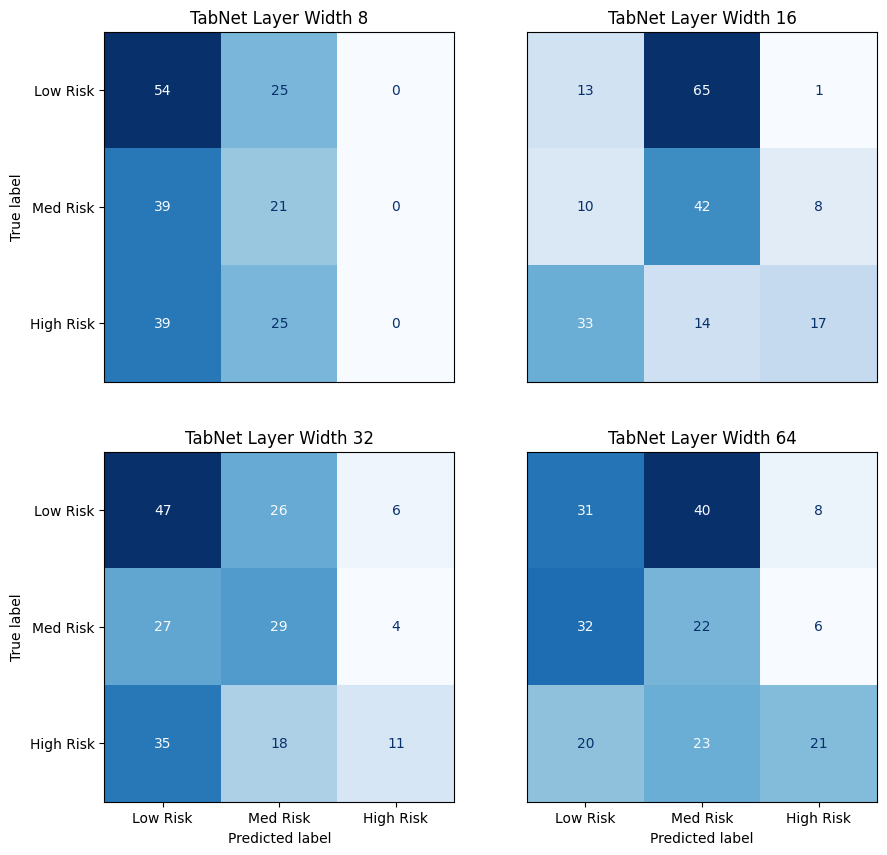

In [ ]:
display_label = ['Low Risk', 'Med Risk', 'High Risk']
color = 'Blues'
colorbar = False

fig_cm, ax_cm = plt.subplots(2,2, figsize=(10,10))

ax_cm[0,0].set_title('TabNet Layer Width 8')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_8), display_labels = display_label).plot(cmap=color, ax=ax_cm[0,0], colorbar=colorbar)
ax_cm[0, 0].xaxis.set_ticklabels(['', '', ''])
ax_cm[0, 0].set_xlabel('')
ax_cm[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax_cm[0,1].set_title('TabNet Layer Width 16')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_16), display_labels = display_label).plot(cmap=color, ax=ax_cm[0,1], colorbar=colorbar)
ax_cm[0, 1].xaxis.set_ticklabels(['', '', ''])
ax_cm[0, 1].yaxis.set_ticklabels(['', '', ''])
ax_cm[0, 1].set_xlabel('')
ax_cm[0, 1].set_ylabel('')
ax_cm[0, 1].tick_params(axis='both', which='both', bottom=False, left=False)

ax_cm[1,0].set_title('TabNet Layer Width 32')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_32), display_labels = display_label).plot(cmap=color, ax=ax_cm[1,0], colorbar=colorbar)
ax_cm[1, 0].tick_params(axis='y', which='both')

ax_cm[1,1].set_title('TabNet Layer Width 64')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_64), display_labels = display_label).plot(cmap=color, ax=ax_cm[1,1], colorbar=colorbar)
ax_cm[1, 1].yaxis.set_ticklabels(['', '', ''])
ax_cm[1, 1].set_ylabel('')
ax_cm[1, 1].tick_params(axis='y', which='both',left=False)

plt.show()

##### Scores
The chart below displays the performance of all 4 models for accuracy, precision, recall, and F1 scores. Again, all the models performed relatively poorly overall, with the an average score accuracy score of 0.38 with a standard deviation of 0.03. The 8-Width model performed the worst for precision and F1 while the 16-Width model performed the worst for accuracy and recall. The best performing model was the 32-Width model with the highest scores in all four categories.

In [ ]:
scores = [accuracy_score(y_test, y_pred_8),
          accuracy_score(y_test, y_pred_16),
          accuracy_score(y_test, y_pred_32),
          accuracy_score(y_test, y_pred_64)]
f1_scores = [f1_score(y_test, y_pred_8, average='weighted'),
             f1_score(y_test, y_pred_16, average='weighted'),
             f1_score(y_test, y_pred_32, average='weighted'),
             f1_score(y_test, y_pred_64, average='weighted')]
precision_scores = [precision_score(y_test, y_pred_8, average='weighted'),
                    precision_score(y_test, y_pred_16, average='weighted'),
                    precision_score(y_test, y_pred_32, average='weighted'),
                    precision_score(y_test, y_pred_64, average='weighted')]
recall_scores = [recall_score(y_test, y_pred_8, average='weighted'),
                 recall_score(y_test, y_pred_16, average='weighted'),
                 recall_score(y_test, y_pred_32, average='weighted'),
                 recall_score(y_test, y_pred_64, average='weighted')]

def round_scores(scores_list):
    for s in range(len(scores_list)):
        scores_list[s] = round(scores_list[s], 3)

round_scores(scores)
round_scores(f1_scores)
round_scores(precision_scores)
round_scores(recall_scores)

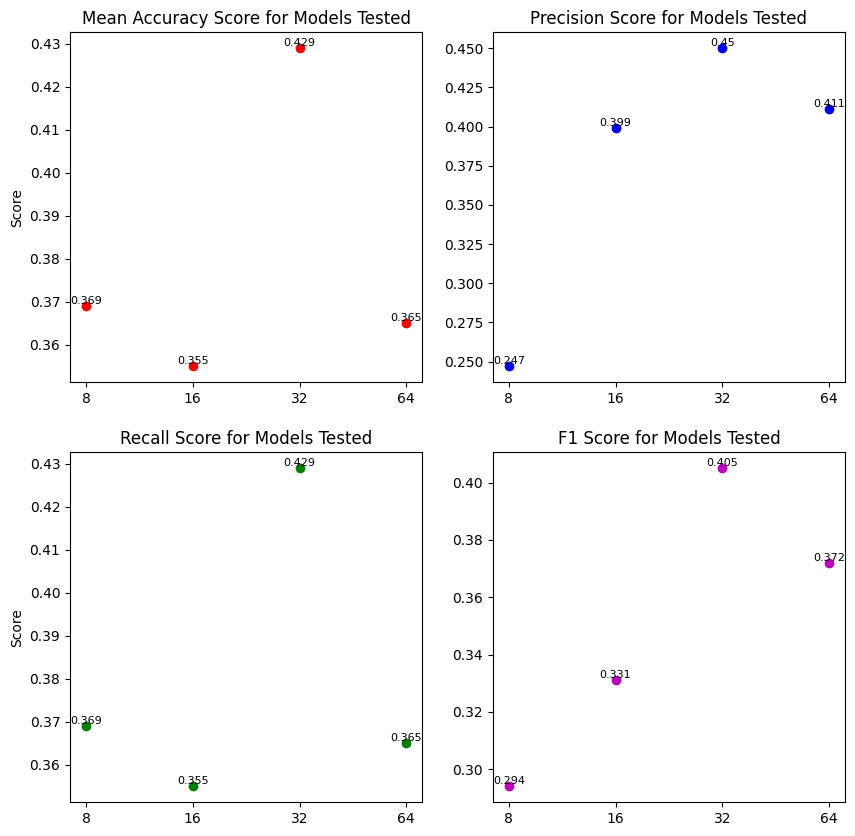

In [ ]:
class_type = ['8', '16', '32', '64']

fig_sc, ax_sc = plt.subplots(2,2, figsize=(10,10))

# Mean Accuracy
ax_sc[0,0].plot(class_type, scores, 'or')
for i in range(len(class_type)):
        ax_sc[0,0].text(i,scores[i],scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[0,0].set_xlabel('')
ax_sc[0,0].set_ylabel("Score")
ax_sc[0,0].set_title("Mean Accuracy Score for Models Tested")

# Precision
ax_sc[0,1].plot(class_type, precision_scores, 'ob')
for i in range(len(class_type)):
        ax_sc[0,1].text(i,precision_scores[i],precision_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[0,1].set_xlabel('')
ax_sc[0,1].set_ylabel('')
ax_sc[0,1].set_title("Precision Score for Models Tested")

# Recall
ax_sc[1,0].plot(class_type, recall_scores, 'og')
for i in range(len(class_type)):
        ax_sc[1,0].text(i,recall_scores[i],recall_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[1,0].set_ylabel('')
ax_sc[1,0].set_ylabel("Score")
ax_sc[1,0].set_title("Recall Score for Models Tested")

# F1
ax_sc[1,1].plot(class_type, f1_scores, 'om')
for i in range(len(class_type)):
        ax_sc[1,1].text(i,f1_scores[i],f1_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[1,1].set_ylabel('')
ax_sc[1,1].set_title("F1 Score for Models Tested")

plt.show()

##### ROC Curves
The chart below displays the ROC Curves and AUC values for each target category for each of the 4 classifiers. Again, this shows that each of the models had a difficult correctly categorizing the data and often did no better than a chance classification. The 16-Width model had the best AUC values for Med and High Risk categories with 0.61 and 0.62, respectively, while the 32-Width model had the highest Low Risk AUC with 0.54. The 8-Width model performed worst of all the models, with almost all the AUCs being lower than a chance selection.

In [ ]:
def create_lb(model, x, y_train, y_test):
    y_score = model.predict_proba(x.values)
    lb = LabelBinarizer().fit(y_train)
    y_ovr = lb.transform(y_test)
    return y_score, y_ovr

y_score_8, y_ovr_8 = create_lb(tabnet_8, X_test, y_train, y_test)
y_score_16, y_ovr_16 = create_lb(tabnet_16, X_test, y_train, y_test)
y_score_32, y_ovr_32 = create_lb(tabnet_32, X_test, y_train, y_test)
y_score_64, y_ovr_64 = create_lb(tabnet_64, X_test, y_train, y_test)

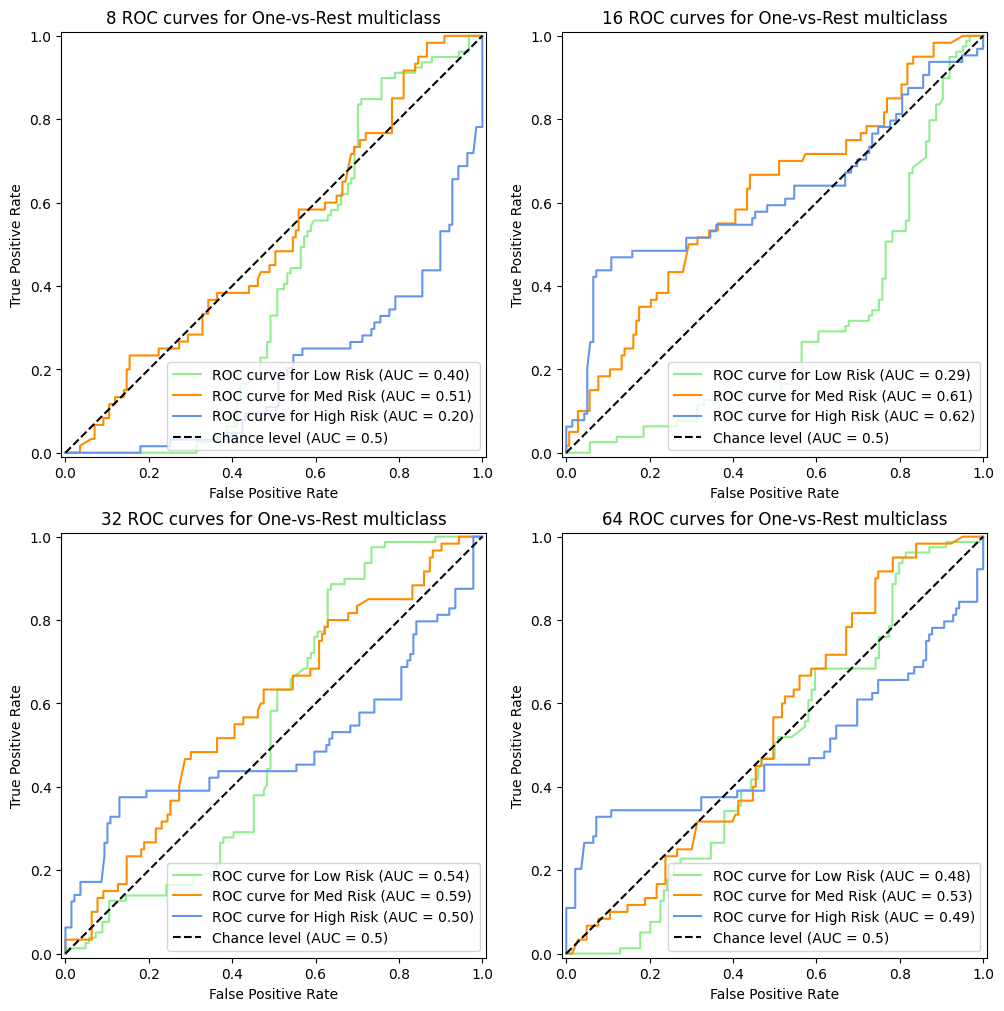

In [ ]:
n_classes = len(np.unique(y_train))
colors = ["lightgreen", "darkorange", "cornflowerblue"]
name_dict = {0:"Low Risk", 1:"Med Risk", 2:"High Risk"}

def plot_rocs(x, y, y_score, y_ovr, name):
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_ovr[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {name_dict[class_id]}",
            color=color,
            ax=ax[x][y],
            plot_chance_level=(class_id == 2),
        )
    _ = ax[x][y].set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"{name} ROC curves for One-vs-Rest multiclass",
    )

fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
plot_rocs(0,0,y_score_8,y_ovr_8,"8")
plot_rocs(0,1,y_score_16,y_ovr_16,"16")
plot_rocs(1,0,y_score_32,y_ovr_32,"32")
plot_rocs(1,1,y_score_64,y_ovr_64,"64")

### Results Summary
* All 4 models performed similarily when assessing the confusion matrix for each model. Most predictions were labelled incorrectly with Low Risk and Medium Risk being mixed up the most and High Risk being correctly classified the least.
* The 32-Width model performed the best across all the score metrics (accuracy, precision, recall, F1) with scores around 0.43 for all metrics.
* All 4 models performed poorly for all the score metrics with no metric being higher than 0.45.
* All 4 models had the highest AUC values for the Medium Risk category, but often performed worse than a chance AUC score.
* The 32-Width model had the most consistent AUC values for all three categories with the highest Low Risk AUC and the 16-Width model had the highest Med and High Risk AUCs.
* Overall, the 32-Width TabNet model performed the best with the highest scores across all the metrics and the most consistent/highest AUCs. The 8-Width TabNet model performed the worst overall with the lowest precison and recall scores and AUCs for all categories.

## Discussion and Conclusion

##### Takeaways
* The 32-Width TabNet model was the best model for this dataset, however none of the TabNet models performed very well at all.
* A deep learning model may not be the best model to choose for this particular dataset, since it has so few data points overall.
* Learned a lot about how to group plots and create subplots for easier visualization.

##### Troubleshooting
* The hardest challenge of this project was determining which hyperparameters to pick for tuning since there were so many options in the TabNet documentation.
* It took a lot of research to see how the TabNet model would interact with the cross validation methods since TabNet is not a very well known model architecture.

##### Improvements
* Reconstruct this experiment with more data points. There were only around 1000 instances of the data. If there were more data, it would be easier to make some generalizations about the distribution of the data and possibly make better decisions about outliers.
* Research other features to add this dataset to help out the model when it is training.
* There was a possible correlation between the BS feature and the RiskLevel target variable. It would be interesting to reconstruct this experiment without the BS feature to see how TabNet performs.

## References

https://www.geeksforgeeks.org/hyperparameter-tuning-using-gridsearchcv-and-kerasclassifier/

https://www.geeksforgeeks.org/tabnet/

https://pypi.org/project/pytorch-tabnet/

https://paperswithcode.com/method/tabnet